Laboratorio 1 - Ramiro Sanes (368397) y Joaquín Guerra (307854)

# Reinforcement Learning Tarea 1 - K Armed Bandits

## Objetivos
- Demostrar entendimiento sobre K-Armed Bandits
- Implementar varios algoritmos vistos en el curso teórico 
- comparar su performance en un mismo problema (ambiente).

## A entregar
- Implementación de agente arbitrario.
- Implementación de agente epsilon-greedy.
- Implementación de agente epsilon-greedy optimista.
- Implementación de agente upper confidence bound.
- Grafique la evolución de las recompensas (reward) a lo largo del tiempo para cada algoritmo, promediado sobre 2000 ejecuciones.
- Escriba un reporte sobre sus implementaciones comparando los distintos agentes implementados.
- [Extra] Implementación de epsilon-greedy con decay.

## Descripción del ambiente a usar

Vamos a usar KBanditsEnv, un ambiente implementado con [Gymnasium](https://gymnasium.farama.org/index.html) pero orientada a [Armed Bandits](https://en.wikipedia.org/wiki/Multi-armed_bandit). 

Recordando el teórico, sabemos que un K Armed Bandit representa una maquina tragamonedas con multiples brazos (K) y donde nuestra recompensa depende de cual brazo tiremos.

En este caso particular, `k_bandits_env/KBanditsGaussian-v0` es el ambiente a utilizar (página 28 del libro de Sutton y Barto), cuenta con 10 brazos (K=10) y por cada interaccion con el ambiente (`step`) nustra recompensa (reward) depende de que brazo elegimos entre los 10 posibles. En este ambiente, todos los brazos tienen una recompensa (que puede ser negativa en algunos casos) y nuestro objetivo es diseñar agentes que maximicen la suma total de recompensas a lo largo de 1000 interacciones con el ambiente (`1000 steps`).

![KBandits](https://miro.medium.com/v2/resize:fit:720/format:webp/1*iguhq3SaQd730c-TYI8QZA.png)

El valor verdadero ($q_*(a)$) de cada brazo es muestreado de una distribución normal con media 0 y varianza 1. La recompensa de cada brazo es muestreada de una distribución normal con media $q_*(a)$ y varianza 1.


> Nota: El agente no tiene acceso a los valores verdaderos de los brazos, solo puede interactuar con el ambiente, es decir, seleccionar un brazo y recibir una recompensa. Nosotros usaremos los valores verdaderos para comparar la performance de los distintos agentes.

Algunas preguntas:
- ¿Es un ambiente estacionario o no estacionario?
- ¿Qué se espera de un agente que seleccione brazos de manera aleatoria en terminos de recompensa y % de veces que selecciona el mejor brazo?

- El ambiente a utilizar es estacionario ya que los rewards asociados a cada palanca se mantienen fijos en cada step (t) del mismo episodio.


- Los resultados a esperar para un agente que seleccione los brazos de manera aleatoria son:
    - Se espera que la recompensa promedio sea 0 ya que el ambiente esta definido de la siguiente manera: **Distribución gausseana de media 0 y varianza 1 entre los 10 brazos.**
    - El % de veces que el agente aleatorio seleciona el mejor brazo va a tender a 1/k.


## Definición del ambiente e imports necesarios

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from Agent import Agent
from Utils import get_env, plot_agents_performance, evaluate_agents

In [2]:
import gymnasium as gym
print(gym.__version__)

1.0.0


Algunas constantes que vamos a usar:

In [3]:
NUM_STEPS = 1000
NUM_EPISODES = 2000

In [4]:
# creamos un entorno de ejemplo, con print_true_values podemos ver los valores verdaderos de las acciones
# PD: en teoria no deberiamos tener acceso a estos valores pero nos sirve para comparar
sample_env = get_env(print_true_values=True) 
print(sample_env.action_space)

True means (q*): [-1.23357334  0.55358679  0.43204728  1.78889804  0.34674542  0.40090434
  0.13785355  0.27809736  0.25746129 -0.54182632]
Discrete(10)


## Implementación de Agentes

En esta sección, exploraremos cómo crear agentes concretos heredando de la clase abstracta `Agent`. Esta clase base define la estructura y el comportamiento general que cualquier agente debe seguir al interactuar con un entorno, proporcionando un marco consistente para diversas estrategias de toma de decisiones.


**Pasos para Implementar un Agente Concreto**

1. **Definir el Constructor (`__init__`)**: Inicializa los atributos específicos del agente, incluyendo su nombre y cualquier parámetro adicional necesario para su estrategia particular.

2. **Implementar `reset_internal_state`**: Establece o reinicia las variables internas que el agente utiliza para rastrear información durante su interacción con el entorno.

3. **Implementar `select_action`**: Define la lógica que el agente emplea para seleccionar una acción basada en la observación actual, la información proporcionada por el entorno y el estado interno del agente.

4. **Implementar `update_internal_state`**: Actualiza el estado interno del agente en función de la nueva información obtenida tras ejecutar una acción, como la nueva observación y la recompensa recibida.

5. **Implementar `get_extra_info`**: Proporciona información adicional sobre el estado o desempeño del agente, útil para análisis o depuración.


Preguntas que pueden ayudar a guiar la implementación de los agentes:
- ¿Qué información necesita el agente para tomar decisiones?
- ¿Cómo se actualiza el estado interno del agente después de cada interacción con el entorno?
- ¿Qué estrategias de selección de acciones basados en el conocimiento previo y la información actual se pueden utilizar?

**Evaluación del Desempeño de los Agentes**

Para analizar cómo se comportan nuestros agentes en el entorno, utilizaremos dos métricas clave:

1. **Recompensa Promedio por Paso:** Esta métrica nos muestra la recompensa media que un agente obtiene en cada paso a lo largo de múltiples episodios. Un valor más alto indica que el agente está tomando decisiones que le reportan mayores beneficios en promedio.

2. **Porcentaje de Selección de la Acción Óptima por Paso:** Esta métrica refleja la frecuencia con la que un agente selecciona la mejor acción disponible en cada paso. Un porcentaje elevado sugiere que el agente identifica y elige consistentemente la acción más beneficiosa.

Para obtener estas métricas, ejecutaremos cada agente durante un número determinado de episodios (`NUM_EPISODES`) y pasos por episodio (`NUM_STEPS`). Durante estas ejecuciones, registraremos las recompensas obtenidas y las acciones seleccionadas. Posteriormente, calcularemos el promedio de las recompensas y el porcentaje de veces que se seleccionó la acción óptima en cada paso.

Estas evaluaciones nos permitirán comparar el rendimiento de diferentes agentes y entender mejor sus comportamientos en el entorno propuesto. 

### Agente arbitrario (random)

Este agente selecciona una acción de manera aleatoria en cada paso, sin considerar ninguna información adicional. Es un agente de referencia simple que nos permitirá comparar el rendimiento de otros agentes más sofisticados.

Para la implementación de este agente no actualizamos el estado en la función update_internal_state dado que no es necesario guardar información sobre recompensas obtenidas ya que el agente no utiliza esta información para la selección de sus acciones.

In [5]:
class RandomAgent(Agent):
    def __init__(self, name):
        super().__init__(name)  

    def reset_internal_state(self):
        
        self.q = np.zeros(self.environment.action_space.n)  # Inicializamos los valores Q en 0
        self.n = np.zeros(self.environment.action_space.n)  # Inicializamos el contador de visitas en 0

    def select_action(self, obs, info):
        return random.randint(0, self.environment.action_space.n - 1)  # Seleccionamos una acción aleatoria
   
    def update_internal_state(self, observation, action, reward, info):
        pass
        # No actualizamos el estado interno porque no lo usa para decidir la proxima accion.
    
    def get_extra_info(self):
        pass

# Example run
random_agent = RandomAgent("RandomAgent")

logs, info = random_agent.play(n_steps = NUM_STEPS, environment = sample_env)

De este modo, podemos tener una estimación de la recompensa ($Q(a)$) de cada brazo.

In [6]:
rewards_per_action = list(map(lambda x: np.array(x), logs['actions_rewards'].values())) # lista de recompensas por acción
labels = list(logs['actions_rewards'].keys()) # lista de etiquetas de las acciones

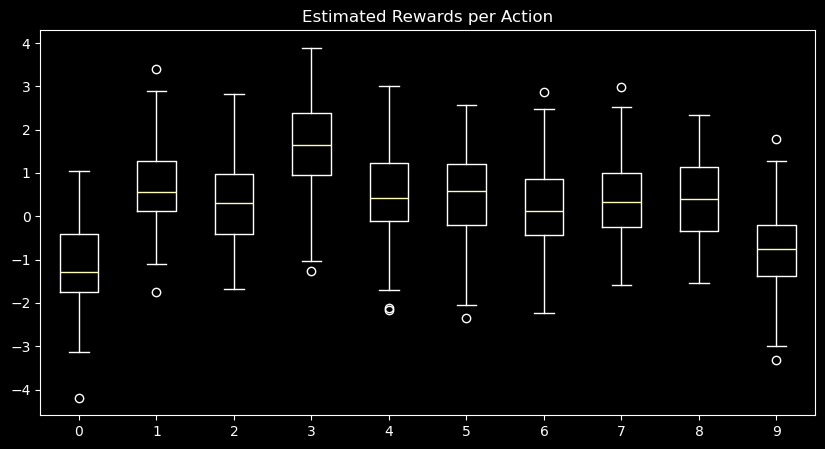

In [7]:
plt.figure(figsize=(10, 5))
plt.boxplot(rewards_per_action, tick_labels=labels)
plt.title('Estimated Rewards per Action')
plt.show()

¿Coincide con el valor verdadero de cada brazo ($q_*(a)$)?

 [ 0.85363837 -0.13877429 -0.48997657 -0.61480495  1.64065077  0.82088061
  0.46723002  0.49572962  2.85701356 -0.77135602]

Los valores estimados de recompensa por acción se acercan bastante a el valor verdadero de cada brazo. 
Esta estrategia debería ser la que mejor estime el valor de Q ya que estadisticamente va a samplear una misma cantidad de veces cada palanca. Probablemente una estrategia que obtenga mejores resultados en performance, se acerque mucho al Q para la accion optima, pero no para el resto de las palancas.

100%|██████████| 2000/2000 [00:06<00:00, 312.99it/s]


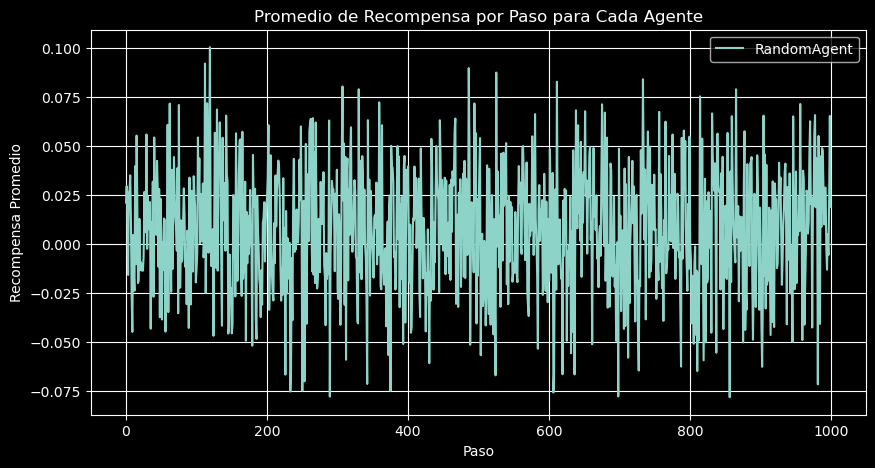

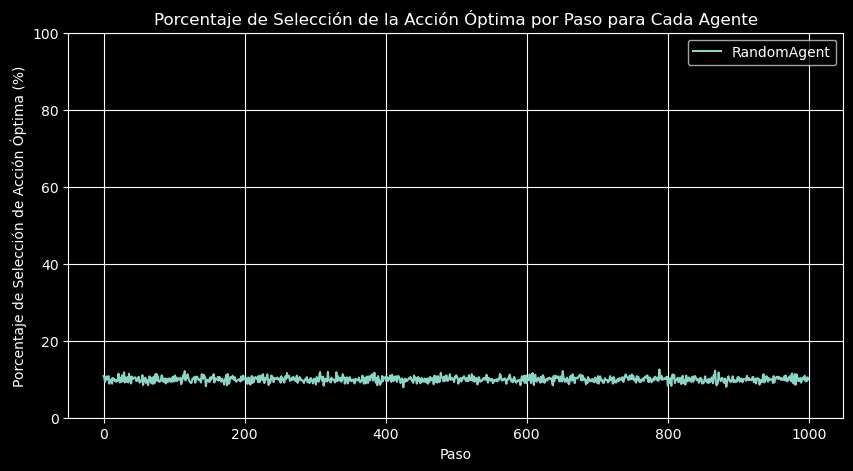

In [8]:
plot_agents_performance([RandomAgent("RandomAgent")], num_steps=NUM_STEPS, num_episodes=NUM_EPISODES)

Como era de esperar, en el primer gráfico observamos que, con el agente aleatorio, no se observa un crecimiento en la recompensa promedio con el pasar de los steps, debido a la aleatorieadad de la política.
Podemos ver que la recompensa promedio está distribuida al rededor del reward 0, tal como está definido el ambiente.

El porcentaje de selección de la acción optima es 10% tal como se esperaría en un agente aleatoria actuando en un ambiente con 10 brazos.

### Agente epsilon-greedy

El agentes epsilon-greedy es una estrategia simple que selecciona la mejor acción con probabilidad $1-\varepsilon$ y una acción aleatoria con probabilidad $\varepsilon$.

**Initialize, for** $a = 1$ to $k$:

$$
Q(a) \gets 0
$$

$$
N(a) \gets 0
$$

**Loop forever:**

$$
A \gets 
\begin{cases} 
\arg\max_a Q(a) & \text{with probability } 1 - \varepsilon \quad \text{(breaking ties randomly)} \\
\text{a random action} & \text{with probability } \varepsilon
\end{cases}
$$

$$
R \gets \text{bandit}(A)
$$

$$
N(A) \gets N(A) + 1
$$

$$
Q(A) \gets Q(A) + \frac{1}{N(A)} \left[ R - Q(A) \right]
$$



In [9]:
array = np.array([1, 2, 5, 4, 5])


max_index = np.where(array == np.max(array))  # Encuentra los índices de los elementos máximos
print(max_index)
random.choice(max_index[0])

(array([2, 4]),)


np.int64(2)

Para la implementación del agente Epsilon Greedy tomamos todos los indices para los cuales el q estimado es igual al mayor y luego elegimos aleatoriamente uno de estos

In [10]:
class EpsilonGreedyAgent(Agent):
    def __init__(self, name, epsilon):
        super().__init__(name)  
        self.epsilon = epsilon
        

    def reset_internal_state(self):
        self.q = np.zeros(self.environment.action_space.n)  # Inicializamos los valores Q en 0
        self.n = np.zeros(self.environment.action_space.n)  # Inicializamos el contador de visitas en 0

    def select_action(self, obs, info):
        if random.random() > self.epsilon:
            # obtenemos indices donde el valor es el maximo del array
            max_index = np.where(self.q == np.max(self.q))
            return random.choice(max_index[0])  # Elegimos una acción aleatoria entre las que tienen el valor máximo
        else:
            return random.randint(0, self.environment.action_space.n - 1)  # Seleccionamos una acción aleatoria
   
    def update_internal_state(self, observation, action, reward, info):
        self.n[action] += 1
        self.q[action] += (1/self.n[action])*(reward-self.q[action])
    
    def get_extra_info(self):
        return {'n_a':self.n,'q_a':self.q}


epsilon_greedy_agent = EpsilonGreedyAgent("EpsilonGreedyAgent", 0.1)

logs, info = epsilon_greedy_agent.play(n_steps = 1000, environment =sample_env)

print(info['n_a'])
print(info['q_a'])
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

[  8.  13.   6. 888.  10.   6.   9.  29.  22.   9.]
[-1.51701824  0.15968962  1.33527374  1.781696   -0.03477376 -0.54133894
  0.77639417  0.72040167  0.63056394 -1.21576292]
Accumulated reward: 1607.31
Mean reward: 1.61


#### Definimos funcion para evaluar la performance de una lista de agentes segun la suma de la media de sus rewards por step

In [11]:
def evaluate_rank_agents(agentsList,num_steps,num_episodes):

    """
    Evalua la performance de una lista de agentes en un entorno dado.
    
    Parametros:
    agentsList (list): Lista de agentes a evaluar.
    num_steps (int): Numero de pasos a ejecutar por episodio.
    num_episodes (int): Numero de episodios para cada agente.
    
    Returns:
    dict: Diccionario con el rendimiento de cada agente, con clave el nombre del agente  y valor la suma de las recompensas medias. Ordenado por la clave
    en orden descendente.
    """
    
    # Evaluamos los agentes
    agents_performance = evaluate_agents(agentsList, num_steps, num_episodes)
    
    # Sumamos las recompensas medias de cada agente
    # y las redondeamos 
    summary_agents_performance = {clave:round(np.sum(valores['average_rewards'])) for clave, valores in agents_performance.items()}

    # Ordenamos el diccionario a devolver por las recompensas totales obtenidas
    agents_performance = sorted(summary_agents_performance.items(), key=lambda x: x[1], reverse=True)
    
    return agents_performance

## Evaluamos el rendimiento de distintos agentes epsilon-greedy variando el parámetro epislon

In [12]:
EpsilonGreedyList = [EpsilonGreedyAgent(f"EpsilonGreedyAgent e={i}", i) for i in [0, 0.02, 0.04, 0.1, 0.2, 0.5, 0.8, 1]]

print(evaluate_rank_agents(EpsilonGreedyList,NUM_STEPS,NUM_EPISODES))

100%|██████████| 2000/2000 [00:09<00:00, 214.72it/s]

[('EpsilonGreedyAgent e=0.04', 1314), ('EpsilonGreedyAgent e=0.1', 1308), ('EpsilonGreedyAgent e=0.02', 1282), ('EpsilonGreedyAgent e=0.2', 1197), ('EpsilonGreedyAgent e=0', 1033), ('EpsilonGreedyAgent e=0.5', 764), ('EpsilonGreedyAgent e=0.8', 307), ('EpsilonGreedyAgent e=1', -7)]


100%|██████████| 2000/2000 [00:11<00:00, 178.83it/s]


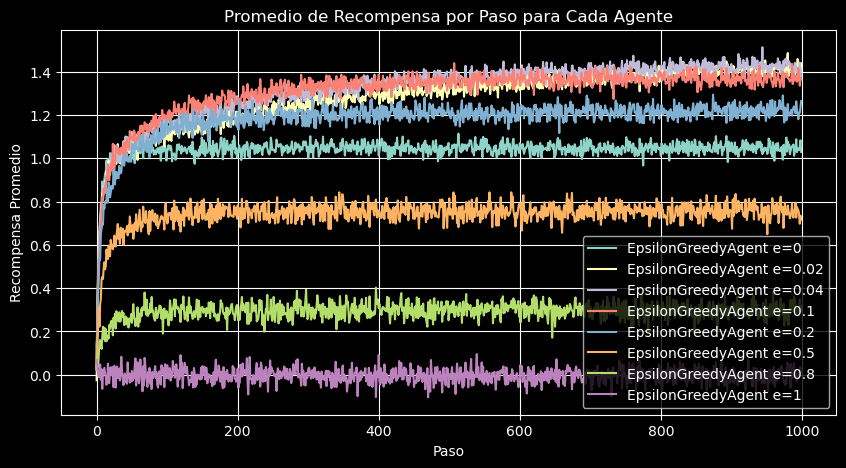

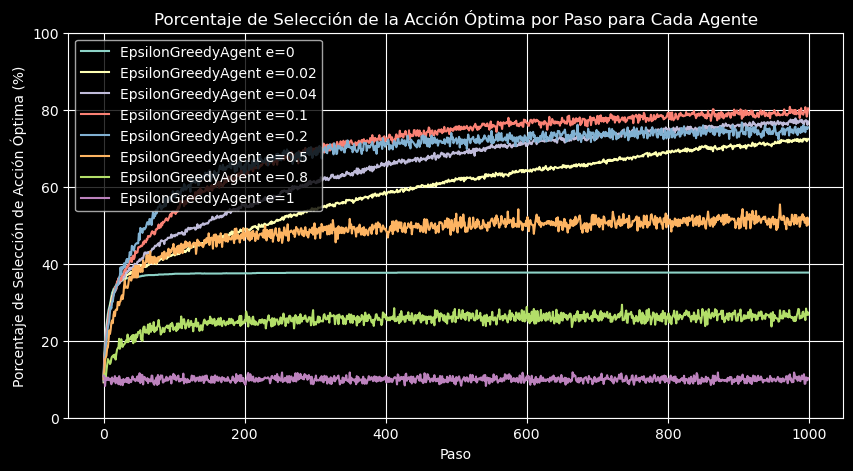

In [13]:
plot_agents_performance(
    EpsilonGreedyList, num_steps=NUM_STEPS, num_episodes=NUM_EPISODES)

> Sugerencia:
> - Probar con otros valores de $\epsilon$ y comparar el rendimiento de los agentes. ¿Cómo afecta el valor de $\epsilon$ al rendimiento del agente?
> - ¿Qué ocurre si incrementamos la cantidad de pasos de entrenamiento? ¿Cómo afecta esto al rendimiento de los agentes?
>
>```python
>plot_agents_performance([
>    EpsilonGreedyAgent("EpsilonGreedyAgent e=a", a),
>    EpsilonGreedyAgent("EpsilonGreedyAgent e=b", b),
>    ...
>    EpsilonGreedyAgent("EpsilonGreedyAgent e=z", z)
>    ], num_steps=NUM_STEPS, num_episodes=NUM_EPISODES)
>```

Comentarios:

- Para una determinada cantidad de steps (que en este ambiente es 1000) hay un epsilon que maximiza el rendimiento. En nuestras simulaciones, este epsilon esta entre 0 y 0.2. 
Para valores por encima de este rango, la performance se ve claramente disminuida.
En un escenario ideal, epsilon optimo sería tendiendo a 0 ya que una vez que se exploró lo suficiente y se conocen las recompensas con más certeza lo mejor es explotar. Al contar con una cantidad limitada de steps, hay que encontrar un balance entre la exploración y la explotación.

    Entre los valores epsilon elegidos para simular, el de mejor performance (recompensa total promedio recibida) fue epsilon = 0.1.      

- Al incrementar la cantidad de pasos, se van a ver beneficiados aquellos agentes con epsilon menor (sin incluir el 0) ya que a medida que disminuye la incertidumbre sobre la distribución de las recompensas optimas, la exploracion sobre otras palancas va a ser menor. 
Cuando la cantidad de pasos es muy grande, el % de aciertos del agente tiende a 1-epsilon.

### Agente epsilon-greedy optimista

El agente epsilon-greedy optimista es una variante del agente epsilon-greedy que inicializa los valores de recompensa estimados ($Q(a)$) con un valor optimista, en lugar de cero. Esto fomenta la exploración de acciones menos conocidas al principio, ya que el agente cree que todas las acciones tienen un valor más alto del que realmente tienen.

Preguntas:
- ¿Qué ocurre si ponemos un valor optimista muy alto?
- ¿Qué ocurre si ponemos un valor optimista muy bajo?

**Initialize, for** $a = 1$ to $k$:

$$
Q(a) \gets q_1
$$

$$
N(a) \gets 0
$$

**Loop forever:**

$$
A \gets 
\begin{cases} 
\arg\max_a Q(a) & \text{with probability } 1 - \varepsilon \quad \text{(breaking ties randomly)} \\
\text{a random action} & \text{with probability } \varepsilon
\end{cases}
$$

$$
R \gets \text{bandit}(A)
$$

$$
N(A) \gets N(A) + 1
$$

$$
Q(A) \gets Q(A) + \alpha (R - Q(A))
$$

> Nota: para esta implementación, usamos $alpha$ en lugar de $\frac{1}{N(A)}$ para actualizar el valor de $Q(A)$. Ver capítulo 2.5 del libro de Sutton y Barto.

In [14]:
class OptimisticEpsilonGreedyAgent(Agent):
    def __init__(self, name, epsilon, q_1, alpha = 0.1):
        super().__init__(name)
        self.epsilon = epsilon
        self.q_1 = q_1
        self.alpha = alpha       

    def reset_internal_state(self):
        n = self.environment.action_space.n.item()
        self.q = np.ones(n) * self.q_1
        self.n = np.zeros(n)


    def select_action(self, obs, info):
        if random.random() > self.epsilon:
            # obtenemos indices donde el valor es el maximo del array
            max_index = np.where(self.q == np.max(self.q))
            return random.choice(max_index[0])  # Elegimos una acción aleatoria entre las que tienen el valor máximo
        else:
            return random.randint(0, self.environment.action_space.n - 1)  # Seleccionamos una acción aleatoria
   
    def update_internal_state(self, observation, action, reward, info):
        self.n[action] += 1
        self.q[action] += (self.alpha)*(reward-self.q[action])

    
    def get_extra_info(self):
        return {
            'n_a':self.n,
                'q_a':self.q
                }

# Example run
optimistic_epsilon_greedy_agent = OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent", epsilon = 0.1, q_1 = 5,alpha=0.1)

logs, info = optimistic_epsilon_greedy_agent.play(n_steps = 1000, environment = sample_env)
print(info['n_a'])
print(info['q_a'])
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

[ 15.  32.  20. 805.  27.  22.  20.  24.  19.  16.]
[-0.0623369   0.52209296  0.93902488  2.0384398   0.40773801  0.82594382
  0.72867486  0.94977319  0.88274464  0.6191576 ]
Accumulated reward: 1481.62
Mean reward: 1.48


In [15]:
OptimisticEGreedyList = [OptimisticEpsilonGreedyAgent(f"OptimisticEpsilonGreedyAgent e={i}   Q1={j}", epsilon = i,   q_1 = j)  for i in [0,0.1,1] for j in [0,1,2,5]]

print(evaluate_rank_agents(OptimisticEGreedyList,NUM_STEPS,NUM_EPISODES))

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:09<00:00, 211.86it/s]

[('OptimisticEpsilonGreedyAgent e=0   Q1=1', 1452), ('OptimisticEpsilonGreedyAgent e=0   Q1=2', 1395), ('OptimisticEpsilonGreedyAgent e=0.1   Q1=1', 1327), ('OptimisticEpsilonGreedyAgent e=0.1   Q1=2', 1292), ('OptimisticEpsilonGreedyAgent e=0   Q1=5', 1278), ('OptimisticEpsilonGreedyAgent e=0.1   Q1=0', 1240), ('OptimisticEpsilonGreedyAgent e=0.1   Q1=5', 1204), ('OptimisticEpsilonGreedyAgent e=0   Q1=0', 1200), ('OptimisticEpsilonGreedyAgent e=1   Q1=2', 10), ('OptimisticEpsilonGreedyAgent e=1   Q1=5', 8), ('OptimisticEpsilonGreedyAgent e=1   Q1=1', 6), ('OptimisticEpsilonGreedyAgent e=1   Q1=0', -4)]


100%|██████████| 2000/2000 [00:10<00:00, 182.69it/s]


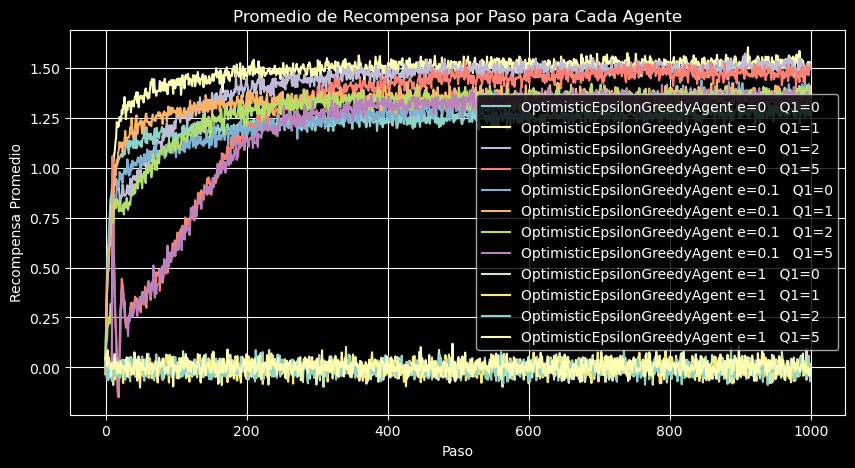

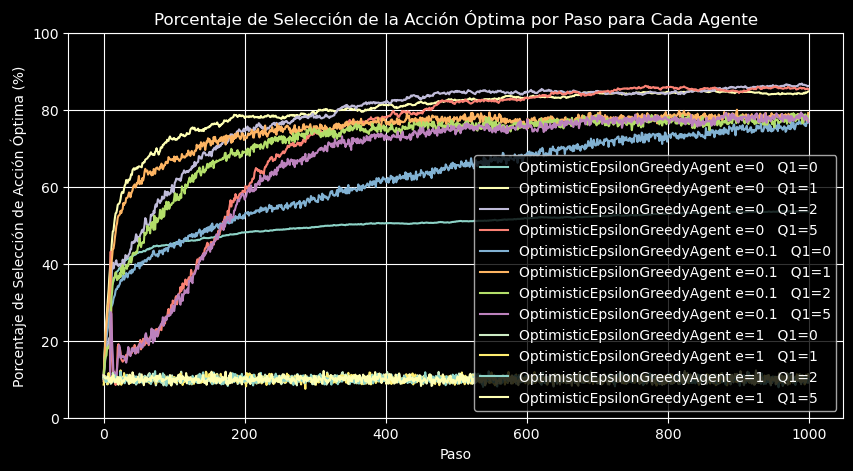

In [16]:
plot_agents_performance(OptimisticEGreedyList, num_steps=NUM_STEPS, num_episodes=NUM_EPISODES)

Comentarios:
-  Para valores optimistas muy altos, el agente se ve obligado a explorar más al inicio hasta que a medida que tenga mas muestras disminuya la incertidumbre de las recompensas de cada palanca.
    A largo plazo el rendimiento de los agentes (siempre y cuando el Q elegido sea mayor a cierto umbral) va a ser similar ya que el Q elegido en un principio, se va a perder entre las recompensas obtenidas.

- Al poner un valor optimista muy bajo (parecido a 0), el agente se comporta muy similar a un agente con politica greedy y no se cumple el objetivo de exploración que se busca con la estrategia.

### Agente Upper Confidence Bound (UCB)

El agente UCB es una estrategia de selección de acciones que equilibra de forma inteligente la exploración y la explotación. En lugar de elegir acciones de forma aleatoria con cierta probabilidad (como en epsilon-greedy), el agente UCB asigna a cada acción una "bonificación de exploración" que disminuye conforme la acción es seleccionada más veces. Esta bonificación se combina con la estimación actual del valor $Q(a)$ para formar un criterio de selección.

Para cada acción $a$, se calcula:

$$
UCB(a) = Q(a) + c \sqrt{\frac{\ln t}{N(a)}}
$$

donde:
- $Q(a)$ es la estimación del valor esperado de la acción $a$.
- $N(a)$ es el número de veces que se ha seleccionado la acción $a$.
- $t$ es el número total de pasos (o iteraciones) realizados hasta el momento.
- $c$ es un parámetro que determina el grado de exploración: un valor mayor favorece la exploración de acciones menos probadas.

**Inicialización:**

Para cada acción $a = 1, \dots, k$:

$$
Q(a) \gets 0
$$
$$
N(a) \gets 0
$$
$$
t \gets 0
$$

**Algoritmo:**

**Loop forever:**

   $$
   t \gets t + 1
   $$

   $$
   A \gets \arg\max_a \left\{ Q(a) + c \sqrt{\frac{\ln t}{N(a)}} \right\}
   $$
   $$
   R \gets \text{bandit}(A)
   $$
   $$
   N(A) \gets N(A) + 1
   $$
   $$
   Q(A) \gets Q(A) + \frac{1}{N(A)} \left( R - Q(A) \right)
   $$
   
>Notas: 
>   - Para aquellas acciones que aún no han sido seleccionadas ($N(a) = 0$), se suele asignar un valor infinito al término de exploración para garantizar que cada acción se pruebe al menos una vez.
>   - Se puede usar una tasa de aprendizaje $\alpha$ para actualizar $Q(A)$ en lugar de $\frac{1}{N(A)}$.

### Preguntas:

- **¿Qué sucede si el parámetro $c$ es muy alto?**
- **¿Qué sucede si el parámetro $c$ es muy bajo?**  

Para la implementación del Agente UCB, sumamos 1e-5 al denominador para evitar errores cuando el agente todavía no haya visitado esa palanca.

In [17]:
# UCB Agent

class UCBAgent(Agent):
    def __init__(self, name, C):
        super().__init__(name) 

        self.C = C

    def reset_internal_state(self):
        n = self.environment.action_space.n.item()
        self.q = np.ones(n) 
        self.n = np.zeros(n)

    def select_action(self, obs, info):
        return np.argmax(self.q + self.C * np.sqrt(np.log(sum(self.n)+1) / (self.n + 1e-5)))  # Añadimos el término de UCB, para obtener t, sumamos los valores del array self.n. Sumamos + 1e-5 para evitar la division por 0 cuando la accion no haya sido visitada
        
   
    def update_internal_state(self, observation, action, reward, info):
        self.n[action] += 1
        self.q[action] += (reward-self.q[action])/(self.n[action])  # Actualizamos el valor Q de la acción seleccionada
    
    def get_extra_info(self):
        return {
            'n_a':self.n,
                'q_a':self.q
                }

# Example run
UCB_agent = UCBAgent("UCBAgent", 1)

logs, info = UCB_agent.play(n_steps = 1000, environment =sample_env)
print(info['n_a'])
print(info['q_a'])
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

[  1.   3.   3. 966.   4.  11.   6.   3.   2.   1.]
[-2.65401124  0.28851288 -0.04156772  1.81054891  0.40181283  0.9961797
  0.53778467 -0.77967496 -0.22857358 -1.09455728]
Accumulated reward: 1758.98
Mean reward: 1.76


In [26]:
UCBList = [UCBAgent(f"UCB Agent C={i}", i) for i in [0.2,0.5, 1, 2, 5, 10]]

print(evaluate_rank_agents(UCBList,NUM_STEPS,NUM_EPISODES))

100%|██████████| 2000/2000 [00:31<00:00, 64.15it/s]

[('UCB Agent C=0.5', 1470), ('UCB Agent C=1', 1457), ('UCB Agent C=0.2', 1452), ('UCB Agent C=2', 1392), ('UCB Agent C=5', 1053), ('UCB Agent C=10', 647)]


100%|██████████| 2000/2000 [00:28<00:00, 69.94it/s]


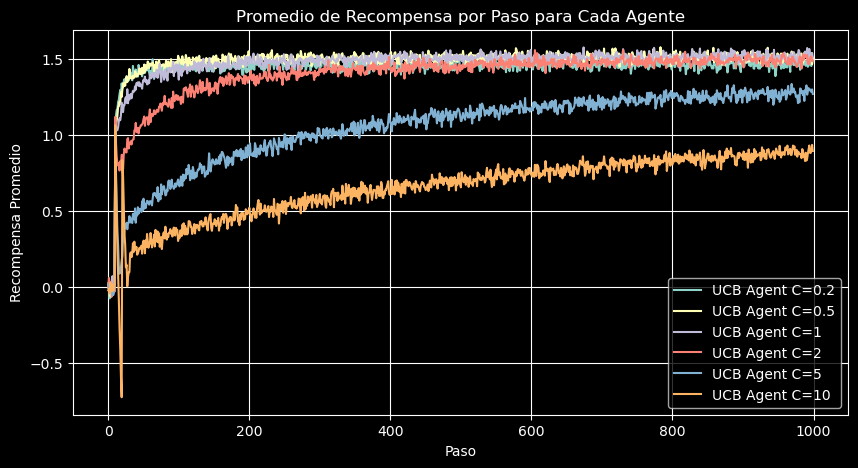

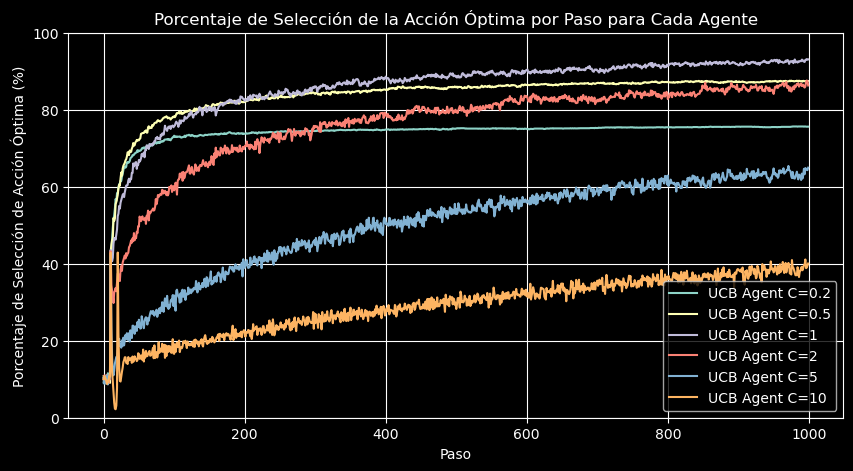

In [19]:
plot_agents_performance(UCBList, num_steps=NUM_STEPS, num_episodes=NUM_EPISODES)

**Comentarios**:

En la politica UCB el factor C determina el balance entre dos terminos para realizar una accion: el reward estimado de cierta accion, y la incertidumbre del mismo. Si C resulta muy grande, el agente va a estar explorando muchas mas veces de las necesarias, ya que probablemente ya tenga un grado de certidumbre de rewards para que una politica mas explotativa resulte en mejor performance. 
Si el C es muy chico, se tiende a realizar acciones mas explotativas, lo cual podria resultar en un bajo rendimiento también debido a que no se han podido explorar otras palancas con la suficiente certidumbre para conocer si son mejores opciones. 
Un C muy cercano a 0 es una política greedy lo cual no permite explorar lo suficiente.


## Tareas

1. Implementar los agentes mencionados.
2. Comentar los resultados obtenidos en las gráficas.
3. Seleccionar de cada agente el/los mejores hiperparámetros.
4. Tomar el mejor candidato de cada agente y compararlos en un mismo gráfico.
5. Explique porque en algunos agentes sus graficas tienen picos (epsilon-greedy optimista y UCB).
6. [Extra] Implementar un agente [epsilon-greedy con decay](https://arxiv.org/pdf/1910.13701).

## ¿Por qué en los agentes epsilon-greedy optimista y UCB se observan picos?

Graficamos el comportamiento de algunos agentes UCB y epsilon-greedy optimista durante 50 pasos para observar mejor los picos

100%|██████████| 2000/2000 [00:01<00:00, 1123.93it/s]


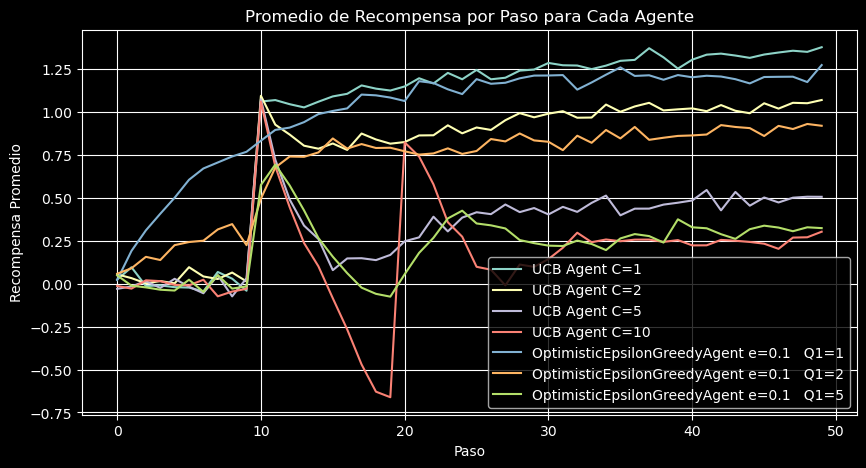

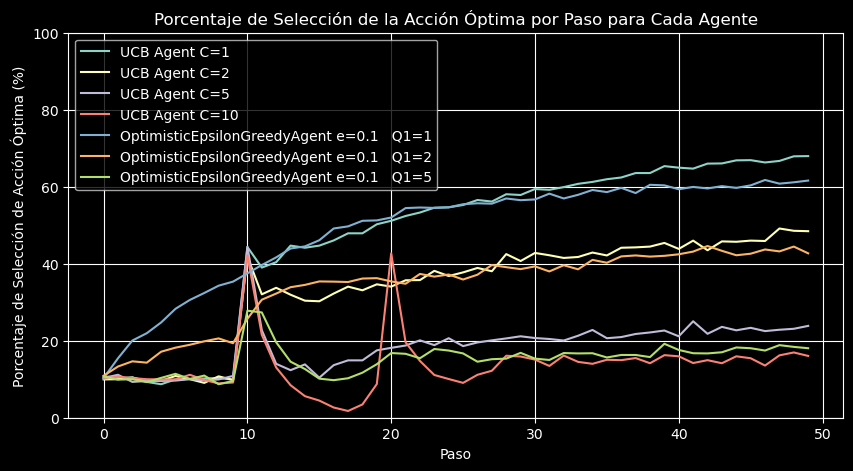

In [20]:
UCBList2 = [UCBAgent(f"UCB Agent C={i}", i) for i in [1, 2, 5, 10]]
OptList2 = [OptimisticEpsilonGreedyAgent(f"OptimisticEpsilonGreedyAgent e={i}   Q1={j}", epsilon = i,   q_1 = j)  for i in [0.1] for j in [1,2,5]]
# mergeamos las 2 listas
UCBList2 = UCBList2 + OptList2
plot_agents_performance(UCBList2, num_steps=50, num_episodes=NUM_EPISODES)

Se observa claramente que los picos se dan en los pasos k y 2k.

En las estrategias epsilon-greedy optimista y UCB el agente se ve obligado a explorar todas las palancas durante los primeros k-1 pasos, en el paso k es probable que seleccione la mejor palanca dado que comienzan a utilizar el conocimiento generado en los primeros k-1 pasos. Luego en el caso de que los hiperparámetros elegidos (C y Q) sean muy altos, el agente nuevamente dará más peso a la incertidumbre de las palancas no conocidas, hasta llegar al paso 2k-1 donde probablemente elija la peor palanca y repita el proceso anterior hasta que la incertidumbre no tenga tanto peso en la decisión.

### Implementación de agente Epsilon-Greedy con Decay

En este caso definimos en la construcción el primer epsilon para luego, al resetear el estado interno, igualar epsilon a este valor inicial y de esta forma evitar que epsilon arrastre el decay del episodio anterior.
A su vez elegimos 0.01 como el valor minimo al que puede decaer epsilon en cada episodio.

In [21]:
class EpsilonGreedyDecay(Agent):
    def __init__(self, name, epsilon, decay_rate):
        super().__init__(name)
        self.epsilon = epsilon
        self.first_epsilon = epsilon
        self.decay_rate = decay_rate
        self.episodes = 0
        

    def reset_internal_state(self):
        #self.q = np.zeros(self.environment.action_space.n)  # Inicializamos los valores Q en 0
        #self.n = np.zeros(self.environment.action_space.n)  # Inicializamos el contador de visitas en 0

        self.q = np.zeros(self.environment.action_space.n)  # Inicializamos los valores Q en 0
        self.n = np.zeros(self.environment.action_space.n)  # Inicializamos el contador de visitas en 0
        self.epsilon = self.first_epsilon  # Inicializamos epsilon a 1

    def select_action(self, obs, info):
        if random.random() > self.epsilon:
            # obtenemos indices donde el valor es el maximo del array
            #print("epsilon: ",self.epsilon)
            max_index = np.where(self.q == np.max(self.q))
            return random.choice(max_index[0])  # Elegimos una acción aleatoria entre las que tienen el valor máximo
        else:
            #print("epsilon: ",self.epsilon)
            return random.randint(0, self.environment.action_space.n - 1)  # Seleccionamos una acción aleatoria
        
   
    def update_internal_state(self, observation, action, reward, info):
        self.n[action] += 1
        self.q[action] += 0.1*(reward-self.q[action]) #(1/self.n[action])*(reward-self.q[action])

        self.epsilon = max(self.decay_rate*self.epsilon, 0.01)  # Decay epsilon, pero no lo dejamos caer por debajo de 0.01
    
    def get_extra_info(self):
        return {'n_a':self.n,'q_a':self.q}

# Example run
EDecayAgent = EpsilonGreedyDecay("EDecayAgent", 1, 0.99)

logs, info = EDecayAgent.play(n_steps = 1000, environment =sample_env)
print(info['n_a'])
print(info['q_a'])
print (f"Accumulated reward: {sum(logs['rewards']):.2f}")
print (f"Mean reward: {logs['rewards'].mean():.2f}")

[  9.   9.   7. 910.  11.  12.  11.  12.   9.  10.]
[-0.62024352 -0.05309613 -0.10352033  1.82732676  0.70401017  0.44043149
  0.17078608 -0.0703721  -0.16592475 -0.38353882]
Accumulated reward: 1588.23
Mean reward: 1.59


In [22]:
EDecayList = [EpsilonGreedyDecay(f"EDecayAgent e={i} decay={j}", i, j)  for i in [0.5, 1] for j in [0.5,0.99, 0.995]]

print(evaluate_rank_agents(EDecayList,NUM_STEPS,NUM_EPISODES))

100%|██████████| 2000/2000 [00:19<00:00, 102.36it/s]

[('EDecayAgent e=0.5 decay=0.99', 1349), ('EDecayAgent e=1 decay=0.99', 1338), ('EDecayAgent e=0.5 decay=0.995', 1326), ('EDecayAgent e=0.5 decay=0.5', 1236), ('EDecayAgent e=1 decay=0.5', 1220), ('EDecayAgent e=1 decay=0.995', 1197)]


100%|██████████| 2000/2000 [00:23<00:00, 84.45it/s]


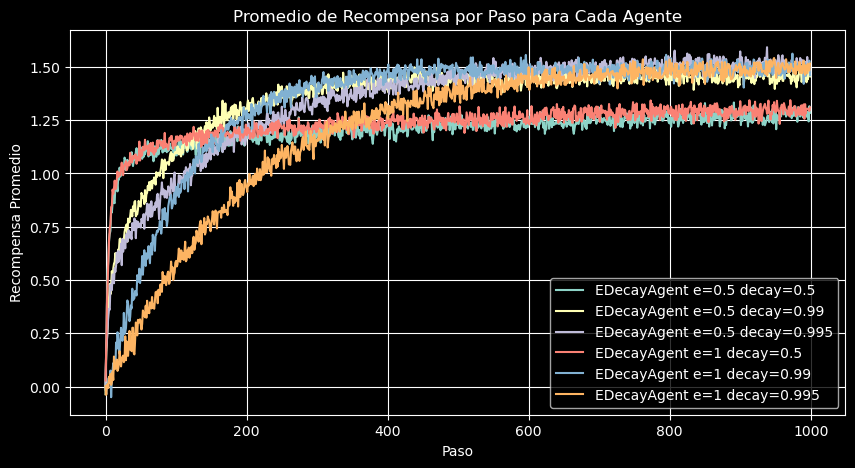

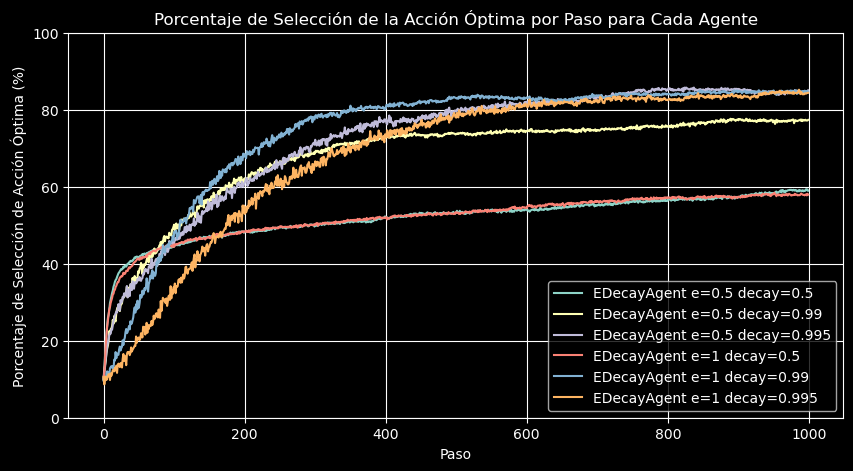

In [23]:
plot_agents_performance(EDecayList, num_steps=NUM_STEPS, num_episodes=NUM_EPISODES)

**Comentarios**

El comportamiento de los agentes es similar al de aquellos que seleccionan la acción a tomar mediante una política epislon-greedy con epsilon óptimos.
Un ratio de decay debe ser muy cercano a 1, para lograr que el agente explore lo suficiento durante una cantidad razonable de steps antes de llegar al epsilon "target" seteado (0.01 en nuestro caso) donde se dedicará a explotar en la mayoría de los casos.

# Evaluando los agentes con mejores hiperparámetros para cada estrategia

100%|██████████| 2000/2000 [00:19<00:00, 103.43it/s]


[('UCB Agent C=1', 1482), ('OptimisticEpsilonGreedyAgent e=0   Q1=1', 1444), ('EDecayAgent e=0.5 decay=0.99', 1358), ('EpsilonGreedyAgent e=0.1', 1311)]


100%|██████████| 2000/2000 [00:21<00:00, 92.95it/s]


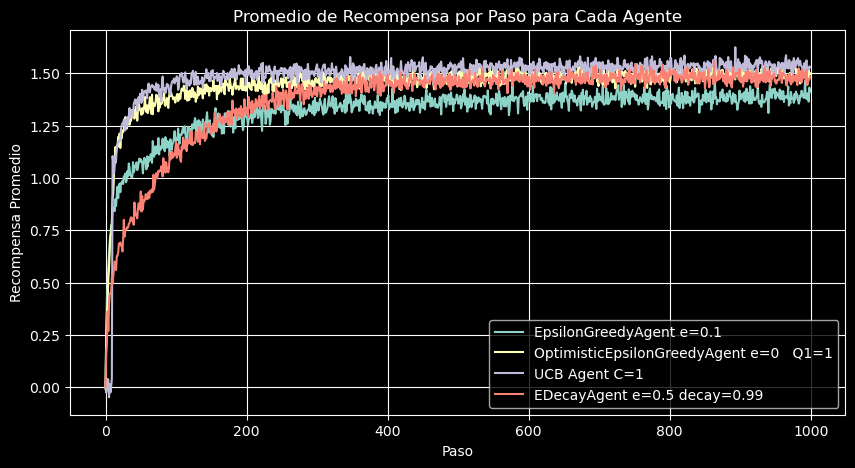

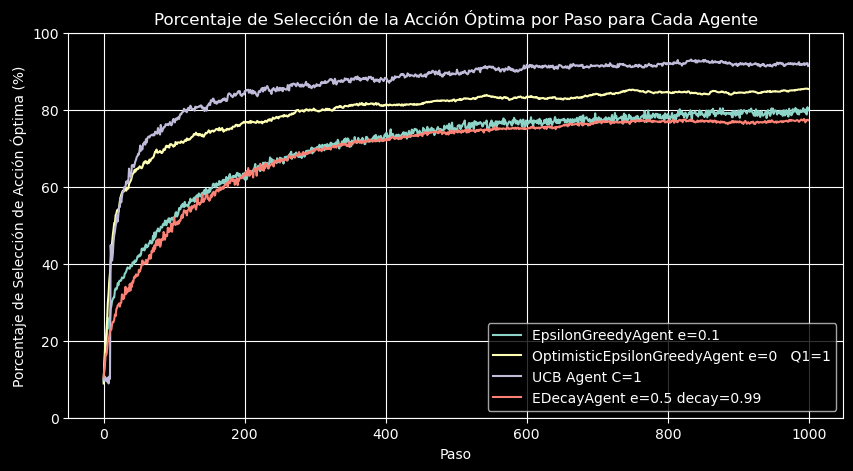

In [25]:
topAgents = [EpsilonGreedyAgent("EpsilonGreedyAgent e=0.1", 0.1),
                OptimisticEpsilonGreedyAgent("OptimisticEpsilonGreedyAgent e=0   Q1=1", epsilon = 0,   q_1 = 1),
                UCBAgent("UCB Agent C=1", 1),
                EpsilonGreedyDecay("EDecayAgent e=0.5 decay=0.99", 0.5, 0.99)
                ]


print(evaluate_rank_agents(topAgents,NUM_STEPS,NUM_EPISODES))


plot_agents_performance(topAgents, num_steps=NUM_STEPS, num_episodes=NUM_EPISODES)

| Estrategia   | Hiperparámetros | Valores      | Recompensa Total Promedio |
| -------------| --------------- | ------------ | ------------------------- |
| UCB          | [C]          | [1]      | 1482
| Optimistic Epsilon Greedy      | [epsilon, Q1]       | [0, 1]       | 1444
| Epsilon Greedy con Decay     | [epsilon, decay]       | [0.5, 0.99]       | 1358
| Epsilon Greedy     |   [epsilon]    | [0.1]      | 1311

Para el ambiente de K Bandits planteado, con K = 10 y para los distintos hiperparámetros simulados, la estrategia con la que obtuvimos mejores resultados fue la **Upper Confidence Bound, con C = 1**.